In [16]:
from casadi import *
from casadi.tools import *
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg

# Empirical power laws
>Let's assume that the average energy consumption of the rat can be modelled with a power law of the form:
$$\frac{d E}{dt} = a + b v^\alpha(t)$$
such that:
    $$E = \int_0^T dE = \int_0^T \left(a+b v^\alpha (t)\right) dt$$
>where $E$ is the total energy consumed from $t=0$ s to the final time $t=T$ s, $v$ is the absolute velocity of the rat, $a$ the rat's power when the velocity is null, $\alpha \in \{1,2\}$. Such laws have been determined experimentally for different mammals and are available in literature. 

> **Setting up the optimal control problem**: Let's assume that our control parameter is the acceleration of the rat on the treadmill. The state can be expressed as:
$$    x=\begin{pmatrix}
    (v_r + v_t)t + x_0\\
    v_r + v_t
    \end{pmatrix}
\quad \textrm{and} \quad 
\dot{x}=\begin{pmatrix}
v_r + v_t\\
u
\end{pmatrix}$$
> where $v_r\leq 0$ is the velocity of the rat in its own frame of reference, $v_t>0$ the velocity of the treadmill, $u$ the acceleration of the rat and $x_0$ its initial position. We want to solve the following problem:
$$\begin{split}
\min_{\substack{ x \in [0,T]\times \mathbb{R}^N_x \\ u \in [0,T]\times \mathbb{R}^N_u}}  \int_{0}^{T} \left(a+b v_r(t)^\alpha \right) dt\\
\textrm{subject to:} \quad
\begin{cases}
\dot{x}=[v_r+v_t,u]^T\\
x(0) = [x_0,(v_t-v_{r}^{max}):0.1]   \\
x(T) = [x_f,(v_t-v_{r}^{max}):0.0]  \qquad t \ \in \ [0,T]\\
[0.0,-0.6] \leq x(t) \leq [L_{t},0.1]   \\
-u_{max} \leq u(t) \leq u_{max}
\end{cases}
\end{split}
\label{problem_pl}$$


>with $L_{t}=0.9$ m the length of the treadmill. The velocity of the treadmill $v_t$ is set to 0.1 m.s$^{-1}$. The maximum velocity that the rat can manage is determined from experimental trajectories. We find that the rats can have a peak velocity of about 0.7 m.s$^{-1}$, which translates into a $0.6$ m.s$^{-1}$ velocity $\dot{x}$ in the frame of the laboratory. Let's assume that the rats can only run against the direction of the treadmill, such that their velocity is constrained to: $-0.7 \leq v_r(t)\leq 0.0$ or $-0.6 \leq \dot{x}(t) \leq 0.1$. The initial and final velocities are left free, whereas the initial and final positions are set to $x_0 = 0.0$ m and $x_f = 0.1$ m. The bounds of the control, the acceleration, are also evaluated from experimental data. It seems that an acceleration $u_{max}=7.5$ m.s$^{-2}$ is realistic. We will assume that the rat can accelerate symmetrically in both directions. We can solve this problem using a collocation method in CasADi. The only unknowns are parameters $a$, $b$ and $\alpha$ that will be chosen based on two articles.


> **Quadratic cost**: In 1958, Ralston investigated the energy expenditure of human participants walking around in a rectangular track at various speed. They wore respirometers such that the oxygen concentrations of the expired air could be measured and turned into an energy equivalent using Weir's method\cite{weir_new_1949}. Ralston settled for a power law quadratic in the velocity:
$$\dot{E}_W = 29+0.0053 v^2 \quad \textrm{cal/kg/min}$$
For a rat with $m_r = 0.3$ kg, we have:
$$\dot{E} = 0.61+1.109\times 10^{-4} v^2 \quad \textrm{J/s}$$

> **Linear cost**: Heglund Cavagna and Taylor measured the work necessary to move the center of mass of animals as a function of their velocity in a level walking task:
    $$\dot{E}_{CM,tot}/M_b = 0.685 v_g + 0.072 \qquad \textrm{W.kg}^{-1}$$
Assuming a mass $m_r = 0.3$ kg, one can rewrite (\ref{linear_cost}) as:
$$    \dot{E} = 0.2055 v_g + 0.0216 $$


> Optimal control computations: The two problems are solved simultaneously using CasADi's collocation technique.

In [17]:
# conversion
#  + 6.03  M^{-0.303}
6.03*0.3**(1-0.303)


2.605378510339309

0.0021855357770455635

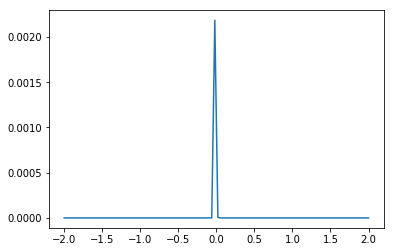

In [64]:
x = np.linspace(-2,2,num=100)
y = heaviside(x,300,-0.01,1) - heaviside(x,300,-0.000001,1)
#y /=  np.max(y)
plt.plot(x,y)
np.max(y)
#x[np.argmax(y)]
#y

In [65]:
def heaviside(x,k,mu,amp):
    '''This function generates a Heaviside step function of steepness k, centered around mu and of amplitude amp'''
    return(amp/(1+np.exp(-2*k*(x-mu))))

def reward_function2(t,dt,reward_max,x,sigma_x,mu_x):
    '''This function generates the infinitesimal reward function with a width of the well dt, the area
    of the well equal to reward_max, centered spatially around mu_x with a Gaussian spread equal to sigma_x'''
    mu=7.0 #the reward peak is centered around this value
    coeff_rwd_decrease = (-0.38*reward_max+reward_max)/(15.0-mu) #experimental coefficient for the linear decrease of the reward
    amplitude = heaviside(x=t,k=100,mu=mu+dt,amp=reward_max/dt+coeff_rwd_decrease)+heaviside(x=t,k=100,mu=mu-dt,amp=-reward_max/dt)
    return(amplitude*np.exp(-(x-mu_x)**2/2/sigma_x**2))   

def penalty2(t,mut,kt,height,x,mux,kx):
    '''This function generates the infinitesimal penalty function, centered timewise around mut, with steepness kt
    and centered spatially around mux with steepness kx. The height of the time step can be adjusted with height.'''
    amplitude = heaviside(-t,kt,-mut,height)
    return(amplitude/(1+np.exp(2*(x-mux)*kx)))

def optimal_trajectory(cost,a,b,x0,xf,tf,vtapis,kxpenalty,reward_max):
    '''This function takes parameters a, b, initial position x0 and final position xf and 
    computes the OC problem assuming either a linear cost (cost='linear', Int_0^T a+b*v dt), 
    or a quadratic one (cost='quadratic',Int_0^T a+b*v*v dt). It returns respectively the 
    optimal trajectory, the associated time array, the optimal 
    velocity and its associated time array.'''
    Ltread=0.9
    nk = 500
    mu=0.1    # Control discretization
    kT=mu/1
    
    
    # Declare variables
    t  = SX.sym("t")    # time
    u  = SX.sym("u")    # control

    states = struct_symSX([
            entry('x',shape=2),    #  states
            entry('L')             #  helper state: Langrange integrand
         ])

    # Create a structure for the right hand side
    rhs = struct_SX(states)
    x = states['x']
    rhs["x"] = vertcat(x[1],u)
        
    if cost=='linear':  #Choose between linear and quadratic power law
        #rhs["L"] = a*(1-heaviside(x[1]-vtapis,300,-0.01,1))+b*fabs(x[1]-vtapis)+reward_function2(t=t,dt=0.1,reward_max=reward_max,x=x[0],sigma_x=0.1,mu_x=0.1)+penalty2(t=t,mut=7.0,kt=100,height=1.0,x=x[0],mux=0.1,kx=kxpenalty)
        rhs["L"] = a*(1/0.0021)*(heaviside(x[1],300,-0.01,1) - heaviside(x[1],300,-0.000001,1))+b*fabs(x[1]-vtapis)+reward_function2(t=t,dt=0.1,reward_max=reward_max,x=x[0],sigma_x=0.1,mu_x=0.1)+penalty2(t=t,mut=7.0,kt=100,height=1.0,x=x[0],mux=0.1,kx=kxpenalty)
    elif cost=='quadratic':
        #rhs["L"] = a*(1-heaviside(x[1]-vtapis,300,-0.01,1))+b*(x[1]-vtapis)**2+reward_function2(t=t,dt=0.1,reward_max=reward_max,x=x[0],sigma_x=0.1,mu_x=0.1)+penalty2(t=t,mut=7.0,kt=100,height=1.0,x=x[0],mux=0.1,kx=kxpenalty)
        rhs["L"] = a*(1/0.0021)*(heaviside(x[1],300,-0.01,1) - heaviside(x[1],300,-0.000001,1))+b*(x[1]-vtapis)**2+reward_function2(t=t,dt=0.1,reward_max=reward_max,x=x[0],sigma_x=0.1,mu_x=0.1)+penalty2(t=t,mut=7.0,kt=100,height=1.0,x=x[0],mux=0.1,kx=kxpenalty)
    # ODE right hand side function
    f = Function('f', [t,states,u],[rhs])

    # Objective function (meyer term)
    m = Function('m', [t,states,u],[states["L"]])

    # Control bounds
    u_min = -7.5
    u_max = 7.5
    u_init = 0.0

    u_lb = np.array([u_min])
    u_ub = np.array([u_max])
    u_init = np.array([u_init])

    # State bounds and initial guess
    x_min =  [0.0,   vtapis-0.7, -inf]
    x_max =  [Ltread,vtapis,  inf]
    xi_min = [x0,  vtapis-0.7,  0.0]
    xi_max = [x0,  vtapis,  inf]
    xf_min = [xf,  vtapis-0.7, -inf]
    xf_max = [xf,  vtapis,  inf]
    x_init = [ 0.0,  0.0,  0.0]

    # Dimensions
    nx = 3
    nu = 1

    # Choose collocation points
    tau_root = [0] + collocation_points(3,"radau")

    # Degree of interpolating polynomial
    d = len(tau_root)-1

    # Size of the finite elements
    h = tf/nk

    # Coefficients of the collocation equation
    C = np.zeros((d+1,d+1))

    # Coefficients of the continuity equation
    D = np.zeros(d+1)

    # Dimensionless time inside one control interval
    tau = SX.sym("tau")

    # All collocation time points
    T = np.zeros((nk,d+1))
    for k in range(nk):
        for j in range(d+1):
            T[k,j] = h*(k + tau_root[j])

    # For all collocation points
    for j in range(d+1):
    # Construct Lagrange polynomials to get the polynomial basis at the collocation point
        L = 1
        for r in range(d+1):
            if r != j:
                L *= (tau-tau_root[r])/(tau_root[j]-tau_root[r])

        # Evaluate the polynomial at the final time to get the coefficients of the continuity equation
        lfcn = Function('lfcn', [tau],[L])
        D[j] = lfcn(1.0)

        # Evaluate the time derivative of the polynomial at all collocation points to get the coefficients of the continuity equation
        tfcn = Function('tfcn', [tau],[tangent(L,tau)])
        for r in range(d+1):
            C[j,r] = tfcn(tau_root[r])

    # Structure holding NLP variables
    V = struct_symMX([
      (
       entry("X",repeat=[nk+1,d+1],struct=states),
       entry("U",repeat=[nk],shape=nu)
      )
    ])

    vars_lb   = V()
    vars_ub   = V()
    vars_init = V()

    # Set states and its bounds
    vars_init["X",:,:] = repeated(repeated(x_init))
    vars_lb["X",:,:]   = repeated(repeated(x_min))
    vars_ub["X",:,:]   = repeated(repeated(x_max))

    # Set controls and its bounds
    vars_init["U",:] = repeated(u_init)
    vars_lb["U",:]   = repeated(u_min)
    vars_ub["U",:]   = repeated(u_max)

    # State at initial time
    vars_lb["X",0,0] = xi_min
    vars_ub["X",0,0] = xi_max

    # State at end time
    vars_lb["X",-1,0] = xf_min
    vars_ub["X",-1,0] = xf_max

    # Constraint function for the NLP
    g = []
    lbg = []
    ubg = []

    # For all finite elements
    for k in range(nk):

        # For all collocation points
        for j in range(1,d+1):

        # Get an expression for the state derivative at the collocation point
            xp_jk = 0
            for r in range (d+1):
                xp_jk += C[r,j]*V["X",k,r]

            # Add collocation equations to the NLP
            fk = f(T[k][j], V["X",k,j], V["U",k])
            g.append(h*fk - xp_jk)
            lbg.append(np.zeros(nx)) # equality constraints
            ubg.append(np.zeros(nx)) # equality constraints

        # Get an expression for the state at the end of the finite element
        xf_k = 0
        for r in range(d+1):
            xf_k += D[r]*V["X",k,r]

        # Add continuity equation to NLP
        g.append(V["X",k+1,0] - xf_k)
        lbg.append(np.zeros(nx))
        ubg.append(np.zeros(nx))

    # Concatenate constraints
    g = vertcat(*g)

    # Objective function
    f = m(T[nk-1][d],V["X",nk,0],V["U",nk-1])

    # NLP
    nlp = {'x':V, 'f':f, 'g':g}

    ## ----
    ## SOLVE THE NLP
    ## ----

    # Set options
    opts = {}
    opts["expand"] = True
    #opts["ipopt.max_iter"] = 4

    # Allocate an NLP solver
    solver = nlpsol("solver", "ipopt", nlp, opts)
    arg = {}

    # Initial condition
    arg["x0"] = vars_init

    # Bounds on x
    arg["lbx"] = vars_lb
    arg["ubx"] = vars_ub

    # Bounds on g
    arg["lbg"] = np.concatenate(lbg)
    arg["ubg"] = np.concatenate(ubg)

    # Solve the problem
    res = solver(**arg)

    # Print the optimal cost
    print("optimal cost: ", float(res["f"]))

    # Retrieve the solution
    opt = V(res["x"])

    # Get values at the beginning of each finite element
    x0_opt = opt["X",:,0,"x",0]
    x1_opt = opt["X",:,0,"x",1]
    x2_opt = opt["X",:,0,"L"]

    u_opt = opt["U",:,0]

    tgrid = np.linspace(0,tf,nk+1)
    tgrid_u = np.linspace(0,tf,nk)
    
    return(x0_opt,x1_opt,tgrid,u_opt,tgrid_u)

def cost(cost,v,a,b,vtapis):
    cos=0
    dt=7/len(v)
    n=0
    if cost=='quadratic':
        for i in range(len(v)):
            cos+=(a+b*(v[i]-vtapis)**2)*dt
        print("Cost of constant running at vt: ",(a+b*vtapis**2)*7.0)
    elif cost=='linear':
        for i in range(len(v)):
            cos+=(a+b*fabs(v[i]-vtapis))*dt
        print("Cost of constant running at vt: ",(a+b*vtapis)*7.0)
    return(cos)

## Linear cost

> Firstly, let's compute the optimal trajectory minimizing a power law linear with respect to the velocity of the rat. Heglund, Cavagna & Taylor (1981) derived an average power law valid for all mammals (the mass of the rat is taken to be $m=0.3$ kg): 

$$\dot{E} = 0.2055 v_g + 0.0216$$


## Linear cost 2 (different parameters)

> Relying on metabolic expenditure, from Taylor, Heglun & Maloiy (1982). The mass of the rat is taken to be $m=0.3$ kg: 

$$\dot{E} = 4.696 v_g + 2.605 $$


## Quadratic cost

In his 1958 paper, Ralston derived the following power law for people performing a walking task:
$$\dot{E}_W = 29+0.0053 v^2 \quad \textrm{cal/kg/min}$$
For a rat with $m_r = 0.3$ kg, we have:
$$\dot{E} = 0.61+1.109\times 10^{-4} v^2 \quad \textrm{J/s}$$

# Computations and plots









In [66]:
# PARAMETERS FOR THE COMPUTATION
vtapis = 0.1
kxpenalty=100  # steepness of penalty cost (the higher the steeper: 100 very steep, 3 slightly, 1 very diffused)
x0 = 0.0     # initial position
xf = 0.1     # final position 
tf = 10.     # final time (duration of experiment)
reward_max=1.0  #maximum reward given to the rat for ET=7


# COMPUTATION
xl,xdotl,tl,accl,tal = optimal_trajectory(cost='linear',a=0.01,b=10,x0=x0,xf=xf,tf=tf,vtapis=vtapis,kxpenalty=kxpenalty,reward_max=reward_max)
xq,xdotq,tq,accq,taccq = optimal_trajectory(cost='quadratic',a=0.01,b=10,x0=x0,xf=xf,tf=tf,vtapis=vtapis,kxpenalty=kxpenalty,reward_max=reward_max)
#xl,xdotl,tl,accl,tal = optimal_trajectory(cost='linear',a=0.0216,b=0.2055,x0=x0,xf=xf,tf=tf,vtapis=vtapis,kxpenalty=kxpenalty,reward_max=reward_max)
#xl2,xdotl2,tl2,accl2,tal2 = optimal_trajectory(cost='linear',a=2.605,b=4.696,x0=x0,xf=xf,tf=tf,vtapis=vtapis,kxpenalty=kxpenalty,reward_max=reward_max)
#xq,xdotq,tq,accq,taccq = optimal_trajectory(cost='quadratic',a=0.61,b=1.109E-04,x0=x0,xf=xf,tf=tf,vtapis=vtapis,kxpenalty=kxpenalty,reward_max=reward_max)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    26996
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3000

Total number of variables............................:     6510
                     variables with only lower bounds:        1
                variables with lower and upper bounds:     4506
                     variables with only upper bounds:        0
Total number of equality constraints.................:     6000
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  87  1.1771948e+00 1.68e-01 1.60e+14  -1.0 3.13e+01   5.8 1.64e-01 1.97e-02h  1
  88  1.4160575e+00 1.63e-01 1.59e+14  -1.0 2.06e+01   5.3 2.88e-01 2.95e-02h  1
  89  1.5200906e+00 1.61e-01 1.57e+14  -1.0 1.79e+01   4.8 1.97e-03 1.29e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.5208977e+00 1.61e-01 1.63e+14  -1.0 2.45e+01   9.8 1.17e-03 1.02e-04h  1
  91  1.5214510e+00 1.61e-01 1.65e+14  -1.0 2.75e+01  10.2 2.00e-04 7.28e-05h  1
  92  1.5229287e+00 1.61e-01 1.65e+14  -1.0 2.85e+01   9.7 1.55e-04 1.83e-04h  1
  93  1.5231848e+00 1.61e-01 1.65e+14  -1.0 2.73e+01  10.1 3.94e-05 3.30e-05h  1
  94r 1.5231848e+00 1.61e-01 1.00e+03  -0.8 0.00e+00   9.7 0.00e+00 3.32e-07R  4
  95r 1.6439946e+00 1.48e-01 2.49e+03  -0.8 1.80e+02    -  1.20e-02 9.00e-04f  1
  96r 2.1383940e+00 1.63e-01 2.15e+03  -0.8 8.92e+01    -  5.75e-03 9.56e-03f  1
  97r 2.1603134e+00 1.69e-01 1.88e+03  -0.8 1.92e+00   2.0 4.48e-02 1.43e-02f  1
  98r 2.1908608e+00 1.74e-01

 186r 2.4135458e+00 1.43e-01 8.54e+01  -1.0 4.17e-02   3.3 2.72e-01 2.57e-01f  1
 187r 2.4145284e+00 1.42e-01 1.22e+02  -1.0 4.75e-02   2.8 2.26e-01 3.12e-01f  1
 188r 2.4146917e+00 1.42e-01 4.26e+01  -1.0 2.89e-03   4.2 1.00e+00 1.00e+00f  1
 189r 2.4150415e+00 1.42e-01 6.49e+01  -1.0 4.76e-03   3.7 1.00e+00 7.10e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190r 2.4162413e+00 1.42e-01 7.59e+01  -1.0 1.15e-02   3.2 1.00e+00 8.45e-01f  1
 191r 2.4167826e+00 1.42e-01 3.15e+01  -1.0 5.03e-03   3.6 1.00e+00 1.00e+00f  1
 192r 2.4169851e+00 1.42e-01 2.94e+01  -1.0 2.49e-03   4.1 1.00e+00 1.00e+00f  1
 193r 2.4171336e+00 1.42e-01 1.06e+02  -1.0 2.41e-02   3.6 6.69e-01 2.49e-01f  1
 194r 2.4185509e+00 1.41e-01 6.71e+01  -1.0 1.45e-02   3.1 1.00e+00 8.31e-01f  1
 195r 2.4187670e+00 1.41e-01 8.08e+01  -1.0 2.75e-02   3.5 5.20e-01 3.36e-01f  1
 196r 2.4198438e+00 1.40e-01 1.61e+02  -1.0 1.63e-02   3.1 1.00e+00 5.82e-01f  1
 197r 2.4205443e+00 1.40e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280r 3.3213208e+00 1.15e-01 3.03e+03  -1.0 1.22e-02   5.6 9.81e-02 2.17e-01h  1
 281r 3.3213208e+00 1.15e-01 3.31e+03  -1.0 1.13e-02   6.0 3.26e-02 8.48e-02h  1
 282r 3.3213213e+00 1.15e-01 3.32e+03  -1.0 1.78e-02   5.5 4.00e-02 2.45e-01h  1
 283r 3.3213213e+00 1.15e-01 3.59e+03  -1.0 1.14e-02   6.0 1.09e-01 1.28e-01h  1
 284r 3.3213214e+00 1.15e-01 3.57e+03  -1.0 1.12e-02   5.5 2.43e-01 3.54e-02h  1
 285r 3.3213219e+00 1.15e-01 6.56e+03  -1.0 1.05e-02   5.9 1.00e-01 6.33e-01h  1
 286r 3.3213235e+00 1.15e-01 2.92e+03  -1.0 5.46e-03   5.4 7.09e-01 7.15e-01h  1
 287r 3.3213265e+00 1.15e-01 1.76e+03  -1.0 4.25e-03   5.0 1.00e+00 4.48e-01f  1
 288r 3.3725262e+00 1.15e-01 1.75e+03  -1.0 1.89e+01    -  7.54e-02 1.66e-02f  1
 289r 3.4340383e+00 1.15e-01 1.89e+03  -1.0 7.65e+00    -  4.26e-01 4.10e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290r 3.5885938e+00 1.15e-01

 374r 4.5099601e+00 1.08e-01 1.62e+01  -1.7 5.23e-03   2.8 1.00e+00 1.00e+00h  1
 375r 4.5099076e+00 1.08e-01 3.24e+01  -1.7 9.98e-03   2.4 1.00e+00 1.00e+00f  1
 376r 4.5095160e+00 1.08e-01 3.31e+01  -1.7 3.38e-02   1.9 1.00e+00 1.00e+00f  1
 377r 4.5079079e+00 1.08e-01 1.06e+02  -1.7 1.06e-01   1.4 1.00e+00 1.00e+00f  1
 378r 4.4512235e+00 1.08e-01 1.36e+02  -1.7 9.30e-01    -  1.00e+00 1.00e+00f  1
 379r 4.4774455e+00 1.08e-01 6.62e+00  -1.7 3.08e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380r 4.4773218e+00 1.08e-01 3.15e+00  -1.7 1.52e-01    -  1.00e+00 1.00e+00h  1
 381r 4.4766010e+00 1.08e-01 1.20e+00  -1.7 2.34e-01    -  1.00e+00 1.00e+00h  1
 382r 4.4760545e+00 1.08e-01 7.94e-02  -1.7 1.76e-01    -  1.00e+00 1.00e+00h  1
 383r 4.4246986e+00 1.08e-01 3.37e+01  -3.8 6.67e-01    -  8.15e-01 6.34e-01f  1
 384r 4.8681707e+00 1.06e-01 4.86e+02  -3.8 2.75e+01    -  4.88e-02 3.24e-01f  1
 385r 4.8754335e+00 1.12e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470  8.8935516e+00 2.19e-02 4.74e+07  -1.0 7.87e+00   3.7 9.59e-02 3.21e-02h  1
 471  8.8940123e+00 2.18e-02 6.04e+07  -1.0 1.24e+00   5.1 4.88e-01 3.96e-03h  1
 472  8.9036902e+00 2.92e-02 1.75e+06  -1.0 4.19e+00   4.6 1.98e-01 9.97e-02h  1
 473  8.9045969e+00 2.90e-02 1.96e+08  -1.0 2.14e+00   4.1 1.00e+00 5.51e-03h  1
 474  8.9462626e+00 1.40e-02 5.37e+08  -1.0 1.10e+00   3.6 9.59e-01 1.93e-01h  1
 475  8.9723131e+00 1.24e-02 4.43e+08  -1.0 5.37e-01   3.2 2.58e-01 1.18e-01h  1
 476  9.0056106e+00 1.04e-02 3.00e+08  -1.0 4.88e-01   2.7 3.17e-01 1.61e-01h  1
 477  9.0493218e+00 1.28e-02 6.40e+07  -1.0 2.84e+00   2.2 4.10e-01 1.89e-01h  1
 478  9.1226036e+00 1.50e-02 5.92e+07  -1.0 6.40e-01   1.7 4.44e-01 5.80e-01H  1
 479  9.1473232e+00 8.61e-03 2.73e+07  -1.0 3.01e-01   1.3 6.03e-01 4.42e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480  9.1487749e+00 8.54e-03

 567  9.9874905e+00 2.77e-03 3.93e+00  -1.0 9.86e-02   0.4 1.00e+00 1.00e+00f  1
 568  9.9882560e+00 6.19e-04 2.61e-01  -1.0 3.62e-02   0.9 1.00e+00 1.00e+00f  1
 569  9.9834387e+00 4.42e-05 7.36e-01  -1.7 1.45e-02   0.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 570  9.9688771e+00 4.36e-04 3.56e-02  -1.7 4.43e-02  -0.1 1.00e+00 1.00e+00f  1
 571  9.9610004e+00 3.01e-04 1.90e-01  -2.5 7.88e-03   0.3 1.00e+00 1.00e+00h  1
 572  9.9349941e+00 5.33e-03 9.69e-02  -2.5 2.60e-02  -0.1 1.00e+00 1.00e+00h  1
 573  9.8535403e+00 6.65e-02 2.80e+00  -2.5 1.66e-01  -0.6 1.00e+00 1.00e+00h  1
 574  9.7083085e+00 4.92e-02 5.44e-01  -2.5 1.45e-01  -1.1 1.00e+00 1.00e+00h  1
 575  9.5118792e+00 2.66e-02 9.82e-01  -2.5 2.40e-01  -1.6 1.00e+00 1.00e+00h  1
 576  9.2445630e+00 1.11e-01 1.95e+00  -2.5 5.75e-01  -2.1 1.00e+00 1.00e+00h  1
 577  9.2122463e+00 4.39e-01 4.87e+00  -2.5 4.08e-01  -0.7 1.00e+00 1.00e+00h  1
 578  9.1851485e+00 5.37e-01

 664  8.7659913e+00 1.12e-02 8.38e-01  -2.5 6.15e-01  -2.5 1.00e+00 1.00e+00h  1
 665  8.7619797e+00 1.52e-03 1.95e-01  -2.5 1.40e+00  -3.0 1.00e+00 1.00e+00h  1
 666  8.7587648e+00 1.80e-02 2.03e+00  -2.5 2.76e+00  -3.5 1.00e+00 1.00e+00h  1
 667  8.7562027e+00 8.20e-03 7.07e-01  -2.5 1.34e+00  -3.9 1.00e+00 1.00e+00h  1
 668  8.7573967e+00 2.05e-03 2.16e-01  -2.5 1.26e+00  -4.4 1.00e+00 1.00e+00h  1
 669  8.7576427e+00 6.57e-04 7.19e-02  -2.5 3.51e-01  -4.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 670  8.7577079e+00 1.64e-04 2.04e-02  -2.5 8.70e-02  -5.4 1.00e+00 1.00e+00h  1
 671  8.3858841e+00 8.99e-03 2.74e+00  -3.8 3.09e+00  -5.8 7.11e-01 1.00e+00f  1
 672  8.3810233e+00 1.32e-03 1.61e-01  -3.8 7.67e-01  -6.3 1.00e+00 1.00e+00h  1
 673  8.3803146e+00 3.92e-03 4.36e+00  -3.8 2.58e+00  -6.8 1.00e+00 9.55e-01H  1
 674  8.3806452e+00 1.14e-03 7.82e-01  -3.8 2.44e-02   1.1 1.00e+00 1.00e+00f  1
 675  8.3782840e+00 1.14e-04

 764  8.1762730e+00 1.94e-01 2.03e+01  -5.7 1.46e-01   0.7 7.27e-02 2.17e-02h  1
 765  8.1817743e+00 1.46e-01 6.46e+03  -5.7 1.93e-01   0.3 9.82e-06 2.50e-01h  3
 766  8.1892628e+00 1.18e-01 5.23e+03  -5.7 1.41e-01  -0.2 1.00e+00 1.91e-01h  1
 767  8.2434040e+00 3.16e-02 1.40e+03  -5.7 1.46e-01  -0.7 6.36e-01 7.32e-01h  1
 768  8.2645392e+00 3.91e-04 5.07e-01  -5.7 1.66e-01  -1.2 6.05e-01 1.00e+00h  1
 769  8.2586516e+00 2.44e-03 2.29e-01  -5.7 3.15e-01  -1.6 7.74e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 770  8.2542147e+00 4.01e-03 2.54e-01  -5.7 3.96e-01  -2.1 4.92e-01 1.00e+00h  1
 771  8.2524023e+00 2.24e-03 1.94e-01  -5.7 3.98e-01  -2.6 5.76e-01 1.00e+00h  1
 772  8.2516687e+00 1.14e-03 1.06e-01  -5.7 4.01e-01  -3.1 8.74e-01 8.83e-01h  1
 773  8.2510428e+00 5.78e-04 5.61e-02  -5.7 4.14e-01  -3.5 1.00e+00 1.00e+00f  1
 774  8.2505077e+00 2.76e-04 2.63e-02  -5.7 7.83e-01  -4.0 1.00e+00 8.60e-01h  1
 775  8.2500684e+00 1.68e-04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -1.7563777e-01 3.79e-01 6.72e+11  -1.0 1.62e+00   9.2 8.38e-01 1.06e-01h  1
  41  1.1144052e-02 3.27e-01 1.69e+12  -1.0 1.28e+00   9.6 9.42e-01 3.04e-01H  1
  42  1.1533692e-02 3.26e-01 1.42e+14  -1.0 1.25e+00  11.9 7.82e-01 1.95e-03h  1
  43  1.1534869e-02 3.26e-01 2.01e+12  -1.0 2.98e-03  15.0 9.88e-01 1.00e+00h  1
  44  1.1535310e-02 3.26e-01 2.06e+12  -1.0 8.34e-04  15.4 9.37e-01 1.00e+00h  1
  45  1.1536634e-02 3.26e-01 1.23e+12  -1.0 2.80e-03  14.9 1.00e+00 1.00e+00h  1
  46  1.1537108e-02 3.26e-01 1.03e+12  -1.0 4.39e-04  15.4 9.85e-01 9.55e-01h  1
  47  1.1538578e-02 3.26e-01 9.57e+11  -1.0 1.21e-03  14.9 1.00e+00 9.86e-01h  1
  48  1.1539136e-02 3.26e-01 1.18e+12  -1.0 5.80e-04  15.3 1.00e+00 1.00e+00h  1
  49  1.1540812e-02 3.26e-01 1.26e+12  -1.0 3.81e-03  14.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.1545840e-02 3.26e-01

 135  1.3852297e-02 3.44e-01 7.99e+10  -1.0 2.28e-03  13.5 1.00e+00 1.00e+00h  1
 136  1.3951579e-02 3.46e-01 9.10e+10  -1.0 3.79e-02  13.1 1.00e+00 1.00e+00h  1
 137  1.3988806e-02 3.46e-01 2.62e+11  -1.0 6.69e-03  13.5 1.00e+00 1.00e+00h  1
 138  1.4002765e-02 3.47e-01 3.99e+11  -1.0 5.27e-03  13.9 1.00e+00 1.00e+00h  1
 139  1.4044637e-02 3.47e-01 4.79e+10  -1.0 2.77e-02  13.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  1.4170238e-02 5.83e-01 2.93e+10  -1.0 7.09e-02  13.0 1.00e+00 1.00e+00h  1
 141  1.4546991e-02 5.38e-01 2.55e+10  -1.0 7.73e-03  12.5 1.00e+00 1.00e+00h  1
 142  1.4688254e-02 5.18e-01 5.50e+10  -1.0 5.45e-03  12.9 1.00e+00 1.00e+00h  1
 143  1.4741220e-02 5.10e-01 9.24e+10  -1.0 4.11e-03  13.3 1.00e+00 1.00e+00h  1
 144  1.4761079e-02 5.06e-01 1.08e+11  -1.0 1.91e-03  13.8 1.00e+00 1.00e+00h  1
 145  1.4820649e-02 4.95e-01 9.03e+10  -1.0 9.21e-03  13.3 1.00e+00 1.00e+00h  1
 146  1.4999329e-02 4.41e-01

 231  4.3593612e-01 5.41e-02 2.81e+11  -1.0 7.32e+00   2.5 2.05e-01 3.34e-02h  1
 232  4.3668252e-01 5.40e-02 3.35e+11  -1.0 5.95e+00   2.0 1.28e-01 8.82e-04h  1
 233  4.5211356e-01 5.31e-02 3.24e+11  -1.0 6.14e+00   1.5 6.50e-03 1.84e-02h  1
 234  4.5237604e-01 5.30e-02 3.70e+11  -1.0 6.32e+00   1.0 1.26e-01 3.17e-04h  1
 235  4.9561571e-01 5.03e-02 4.13e+11  -1.0 6.38e+00   0.6 2.49e-01 5.23e-02h  1
 236  4.9616076e-01 5.02e-02 4.73e+11  -1.0 6.23e+00   0.1 2.48e-01 6.90e-04h  1
 237  5.0977276e-01 4.94e-02 4.76e+11  -1.0 5.78e+00  -0.4 8.51e-02 1.75e-02h  1
 238  5.1712333e-01 4.89e-02 5.68e+11  -1.0 5.79e+00  -0.9 5.90e-01 9.58e-03h  1
 239  5.6294229e-01 4.59e-02 5.65e+11  -1.0 5.79e+00  -1.4 5.23e-01 6.01e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240  5.6400361e-01 4.59e-02 5.74e+11  -1.0 5.43e+00  -1.8 3.00e-01 1.48e-03h  1
 241  5.9441220e-01 4.39e-02 5.48e+11  -1.0 5.21e+00  -2.3 5.36e-03 4.28e-02h  1
 242  5.9763192e-01 4.37e-02

 333  1.2383991e-01 1.24e+00 1.50e+02  -3.8 4.22e-01   0.9 1.00e+00 8.33e-01h  1
 334  4.5115167e-01 7.97e-02 1.65e+02  -3.8 3.62e-01   1.3 1.00e+00 1.00e+00h  1
 335  4.6010345e-01 9.34e-02 5.81e+02  -3.8 1.76e-01   1.8 8.45e-01 9.22e-01h  1
 336  4.7953714e-01 6.65e-03 1.77e+02  -3.8 1.71e-01   1.3 1.00e+00 1.00e+00h  1
 337  4.8234039e-01 1.49e-04 1.53e+01  -3.8 2.39e-02   0.8 1.00e+00 1.00e+00h  1
 338  4.8117656e-01 1.59e-04 9.95e-01  -3.8 2.11e-02   0.3 1.00e+00 1.00e+00h  1
 339  4.7610119e-01 1.24e-03 2.12e-01  -3.8 5.29e-02  -0.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340  4.6298027e-01 3.35e-03 2.65e-01  -3.8 1.55e-01  -0.6 1.00e+00 1.00e+00h  1
 341  4.3554481e-01 5.79e-03 8.57e-01  -3.8 3.52e-01  -1.1 1.00e+00 1.00e+00h  1
 342  4.0720363e-01 6.03e-03 1.54e-01  -3.8 4.05e-01  -1.6 1.00e+00 1.00e+00h  1
 343  3.8168856e-01 1.75e-03 2.83e-01  -3.8 3.17e-01  -2.1 1.00e+00 1.00e+00h  1
 344  3.6898603e-01 7.00e-04

Cost of constant running at vt:  4.270007763000001
Cost quadratic =  4.27001
Cost of constant running at vt:  0.29505
Cost linear =  0.281412


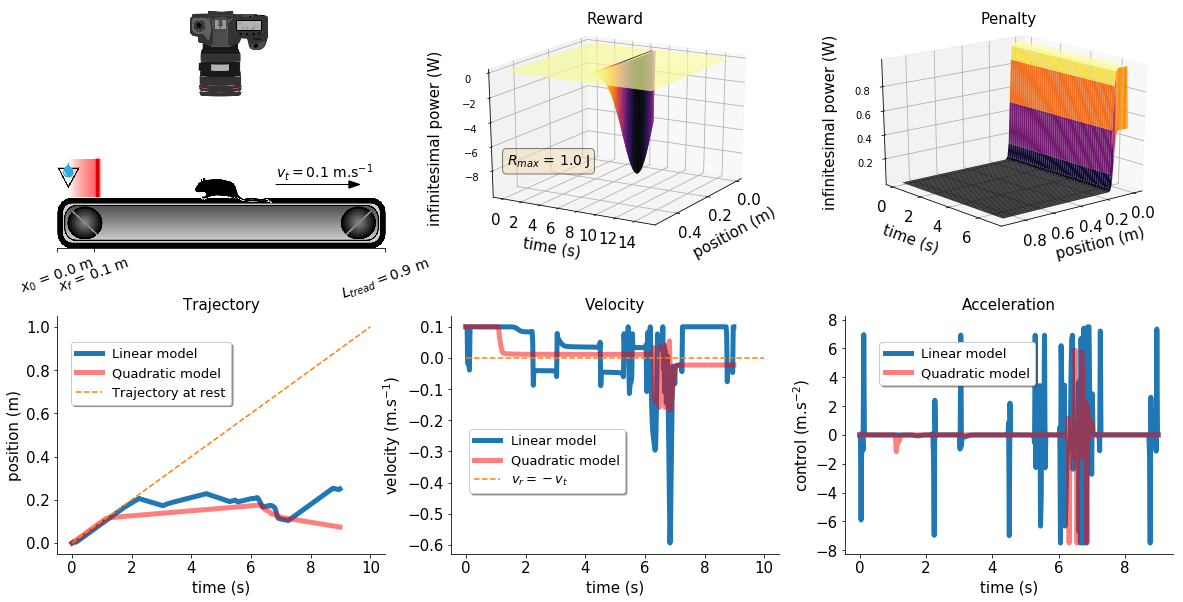

In [67]:
limit=450

#COMPUTE ASSOCIATED COSTS
costq=cost('quadratic',xdotq,0.61,1.109E-04,vtapis)
print("Cost quadratic = ",costq)
costl=cost('linear',xdotl,0.0216,0.2055,vtapis)
print("Cost linear = ",costl)

#GENERATE FIGURE
fig3 = plt.figure(figsize=(20,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=2)
gs = fig3.add_gridspec(6, 6)

# SCHEME OF THE TASK
f3_ax1 = fig3.add_subplot(gs[:3, :2])
img1 = mpimg.imread('experimental_setup.png')
f3_ax1.imshow(img1,aspect='auto')
f3_ax1.spines['top'].set_visible(False)
f3_ax1.spines['right'].set_visible(False) 
f3_ax1.spines['left'].set_visible(False) 
f3_ax1.set_yticks([])
f3_ax1.set_xticks([x0*1000,xf*1000,900])
plt.xticks(rotation=20)
f3_ax1.set_xticklabels([r'$x_0$ = '+str(x0)+' m',r'$x_f$ = '+str(xf)+' m',r'$L_{tread} = 0.9$ m'],size=14)
plt.arrow(600,470,200,0,head_width=20.0,color='black')
plt.text(600,450,r'$v_t = $'+str(vtapis)+' m.s$^{-1}$',size=14)

#REWARD FUNCTION
f3_ax2 = fig3.add_subplot(gs[:3, 2:4],projection="3d")
f3_ax2.set_title('Reward',size=15)
t = np.linspace(0,15,100)
x = np.linspace(0.0,0.50,100)
X,T = np.meshgrid(x,t)
Z = reward_function2(t=T,dt=0.1,reward_max=reward_max,x=X,sigma_x=0.1,mu_x=0.1)
f3_ax2.plot_surface(X, T, Z, rstride=1, cstride=1,cmap='inferno', edgecolor='none')
plt.xlabel('position (m)',size=15,labelpad=10)
plt.xticks(np.arange(0, 0.5, step=0.2))
plt.ylabel('time (s)',size=15,labelpad=10)
f3_ax2.zaxis.set_rotate_label(False) 
f3_ax2.set_zlabel('infinitesimal power (W)',size=15,labelpad=10,rotation=90)
#f3_ax2.set_zticks(np.linspace(0,-10.0,5))
f3_ax2.view_init(20, 30)
plt.xticks(size = 15)
plt.yticks(size = 15)
f3_ax2.text2D(0.17, 0.35, r"$R_{max}$ = "+str(reward_max)+' J', transform=f3_ax2.transAxes,size=14,bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

#PENALTY FUNCTION
f3_ax3 = fig3.add_subplot(gs[:3, 4:],projection='3d')
f3_ax3.set_title('Penalty',size=15)
x = np.linspace(0.0,0.9,100)
t = np.linspace(0.0,7.0)
X,T = np.meshgrid(x,t)
Z = penalty2(t=T,mut=7.0,kt=100,height=1.0,x=X,mux=0.1,kx=kxpenalty)
f3_ax3.plot_surface(X, T, Z, rstride=1, cstride=1,cmap='inferno', edgecolor='none')
plt.xlabel('position (m)',size=15,labelpad=10)
plt.xticks(np.arange(0, 0.9, step=0.2))
plt.yticks(np.arange(0, 7, step=2))
plt.ylabel('time (s)',size=15,labelpad=10)
f3_ax3.zaxis.set_rotate_label(False) 
f3_ax3.set_zlabel('infinitesimal power (W)',size=15,labelpad=10,rotation=90)
#f3_ax3.set_zticks(np.linspace(0,4,5))
f3_ax3.view_init(20, 50)
plt.xticks(size = 15)
plt.yticks(size = 15)


#TRAJECTORY
f3_ax4 = fig3.add_subplot(gs[3:,:2])
f3_ax4.set_title('Trajectory',size=15)
plt.plot(tl[:limit],xl[:limit],label='Linear model',linewidth=5.0,alpha=1.0)
#plt.plot(tl2[:limit],xl2[:limit],label='Linear model 2',linewidth=5.0,alpha=1.0, color='green')
plt.plot(tq[:limit],xq[:limit],label='Quadratic model',linewidth=5.0,alpha=0.5,color='red')
plt.plot(tl,[0.1*t for t in tl],'--',label='Trajectory at rest')
f3_ax4.spines['top'].set_visible(False)
f3_ax4.spines['right'].set_visible(False) 
f3_ax4.legend(fontsize=13,bbox_to_anchor=(.55, .6),shadow=True, ncol=1)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.ylabel('position (m)',size=15)
plt.xlabel('time (s)',size=15)


#VELOCITY
f3_ax5 = fig3.add_subplot(gs[3:, 2:4])
f3_ax5.set_title('Velocity',size=15)
plt.plot(tl[:limit],xdotl[:limit],label='Linear model',linewidth=5.0)
#plt.plot(tl2[:limit],xdotl2[:limit],label='Linear model 2',linewidth=5.0,alpha=1.0, color='green')
plt.plot(tq[:limit],xdotq[:limit],label='Quadratic model',linewidth=5.0,alpha=0.5,color='red')
plt.plot(tl,[0.0 for t in tl],'--',label=r'$v_r=-v_t$')
plt.ylabel(r'velocity (m.s$^{-1}$)',size=15)
plt.xlabel('time (s)',size = 15)
f3_ax5.spines['top'].set_visible(False)
f3_ax5.spines['right'].set_visible(False) 
f3_ax5.legend(fontsize=13,bbox_to_anchor=(.55, .55),shadow=True, ncol=1)
plt.xticks(size = 15)
plt.yticks(size = 15)


#ACCELERATION
f3_ax6 = fig3.add_subplot(gs[3:, 4:])
f3_ax6.set_title('Acceleration',size=15)
plt.plot(tal[:limit],accl[:limit],label='Linear model',linewidth=5.0)
#plt.plot(tal2[:limit],accl2[:limit],label='Linear model 2',linewidth=5.0,alpha=1.0, color='green')
plt.plot(taccq[:limit],accq[:limit],label='Quadratic model',color='red',alpha=0.5,linewidth=5.0)
plt.ylabel(r'control (m.s$^{-2}$)',size=15)
plt.xlabel('time (s)',size=15)
f3_ax6.spines['top'].set_visible(False)
f3_ax6.spines['right'].set_visible(False) 
f3_ax6.legend(fontsize=13,bbox_to_anchor=(.6, .8),shadow=True, ncol=1)
plt.xticks(size = 15)
plt.yticks(size = 15)


plt.savefig('LQ2_Results_kxpenalty'+str(kxpenalty)+'.pdf')
plt.show()